***Importamos las librerías necesarias :***

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

***Guardamos las trayectorias con sus respectivas clases en "complete_df" :***

In [2]:
csv_files = [
    "./Trayectorias/Tipos_de_barcos/longitud_8/Cargo_modificado_compressed_8_v4.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Fishing_modificado_compressed_8_v4.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Military_modificado_compressed_8_v4.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Sailing_modificado_compressed_8_v4.csv",
    "./Trayectorias/Tipos_de_barcos/longitud_8/Tanker_modificado_compressed_8_v4.csv"
]

complete_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    df['Bearing'] = df['Bearing'].round(4)
    grouped = df.groupby('Trajectory_ID')['Bearing'].apply(lambda x: [i for i in x if pd.notna(i)]).reset_index()
    grouped['Type'] = file.split('/')[-1].split('_')[0]
    complete_df = pd.concat([complete_df, grouped], ignore_index=True)

### COMPROBACIÓN BEARING ###
for tipo in complete_df['Type'].unique():
    first_element = complete_df[complete_df['Type'] == tipo].iloc[0]
    print(f"Type: {tipo}, Trajectory_ID: {first_element['Trajectory_ID']}, Bearing: {first_element['Bearing']}")

print()

### COMPROBACIÓN NÚMERO DE TRAYECTORIAS ###
print("Número total de trayectorias:", len(complete_df))
class_counts = complete_df['Type'].value_counts()
print(class_counts)

Type: Cargo, Trajectory_ID: 0, Bearing: [93.1971, 109.8378, 90.9892, 95.7436, 92.3003, 95.8598, 92.0652]
Type: Fishing, Trajectory_ID: 2, Bearing: [77.4715, 335.1613, 117.654, 231.3515, 65.6306, 273.2838, 209.4091]
Type: Military, Trajectory_ID: 5, Bearing: [315.0019, 58.7153, 251.3746, 127.3577, 294.2115, 227.7705, 105.3561]
Type: Sailing, Trajectory_ID: 1, Bearing: [263.4307, 5.6916, 215.2968, 83.4821, 169.0141, 307.5607, 160.1776]
Type: Tanker, Trajectory_ID: 7, Bearing: [77.548, 103.1219, 21.5507, 108.5279, 91.3764, 118.2106, 62.8573]

Número total de trayectorias: 29987
Type
Fishing     6482
Sailing     6382
Military    6343
Tanker      5831
Cargo       4949
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [3]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['Type'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['Type'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de trayectorias en train: {len(train_df)}")
print(train_df['Type'].value_counts())
print()
print(f"Nº de trayectorias en test: {len(test_df)}")
print(test_df['Type'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(5))
print()
print("Ejm. conjunto test:")
print(test_df.head(5))

Nº de trayectorias en train: 23992
Type
Fishing     5186
Sailing     5106
Military    5075
Tanker      4665
Cargo       3960
Name: count, dtype: int64

Nº de trayectorias en test: 5995
Type
Fishing     1296
Sailing     1276
Military    1268
Tanker      1166
Cargo        989
Name: count, dtype: int64

Ejm. conjunto train:
   Trajectory_ID                                            Bearing      Type
0          24960  [349.2476, 207.4894, 113.9077, 209.8313, 334.6...   Sailing
1           7862  [93.3863, 85.2444, 97.9006, 90.1909, 93.4438, ...     Cargo
2           9580  [93.7199, 354.0017, 93.626, 129.0334, 90.5289,...    Tanker
3           8953  [95.8228, 89.9012, 93.3814, 90.6446, 99.652, 9...     Cargo
4          11895  [315.0117, 58.9055, 250.7779, 127.1441, 294.07...  Military

Ejm. conjunto test:
   Trajectory_ID                                            Bearing      Type
0          14677  [89.2398, 283.3184, 136.1258, 349.7497, 174.66...   Fishing
1           3859  [76.4695, 289.

***Pre-procesado de los datos :***

In [4]:
#Convertimos Bearing a un array de numpy
X_train = np.array(train_df['Bearing'].tolist())
X_test = np.array(test_df['Bearing'].tolist())

#Normalizamos los valores de Bearing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Añadimos una dimensión extra para que tenga la forma (n, 1)
X_train = np.expand_dims(X_train, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

#Codificamos las etiquetas de Type
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Type'])
y_test = label_encoder.transform(test_df['Type'])

#Conversión a tensores
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("X_train:", X_train.shape, X_train.device)
print("y_train:", y_train.shape, y_train.device)
print("X_test:", X_test.shape, X_test.device)
print("y_test:", y_test.shape, y_test.device)

Device: cuda
X_train: torch.Size([23992, 1, 7]) cuda:0
y_train: torch.Size([23992]) cuda:0
X_test: torch.Size([5995, 1, 7]) cuda:0
y_test: torch.Size([5995]) cuda:0


# ***CNN1D :***

In [5]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (X_train.shape[2] // 4), 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

***Configuración del modelo :***

In [6]:
k_folds = 5
batch_size = 32
num_epochs = 10
num_classes = 5

***Entrenamiento del modelo :***

In [7]:
train_dataset = TensorDataset(X_train, y_train)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_train_acc = []
fold_train_loss = []
fold_val_acc = []
fold_val_loss = []

best_val_acc = 0
best_epoch_train_acc = []
best_epoch_val_acc = []
best_epoch_train_loss = []
best_epoch_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):

    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_loss = []
    epoch_val_loss = []

    print(f"\n📂 Fold {fold+1}/{k_folds}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = CNN1D(num_classes=num_classes).to(device)

    #Pesos inversamente proporcionales a la frecuencia de las clases
    label_counts = Counter(y_train.cpu().numpy())
    total_count = sum(label_counts.values())
    weights = [total_count / (num_classes * label_counts[label]) for label in range(len(label_counts))]

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val

        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(avg_val_loss)

        print(f"Fold {fold+1} - Epoch {epoch+1} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

    fold_train_acc.append(train_acc)
    fold_val_acc.append(val_acc)
    fold_train_loss.append(avg_train_loss)
    fold_val_loss.append(avg_val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = "./Modelos/v4/representacion_1/longitud_8"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/CNN1D_fold_{fold+1}.pth")
        best_epoch_train_acc = epoch_train_acc.copy()
        best_epoch_val_acc = epoch_val_acc.copy()
        best_epoch_train_loss = epoch_train_loss.copy()
        best_epoch_val_loss = epoch_val_loss.copy()

print("\nRESULTADOS:")
print(f"-> Mean Train Accuracy: {np.mean(fold_train_acc):.4f}%")
print(f"-> Mean Train Loss: {np.mean(fold_train_loss):.4f}")
print(f"-> Mean Validation Accuracy: {np.mean(fold_val_acc):.4f}%")
print(f"-> Mean Validation Loss: {np.mean(fold_val_loss):.4f}")


📂 Fold 1/5


Fold 1 | Epoch 1/10: 100%|██████████| 600/600 [00:08<00:00, 66.98it/s] 


Fold 1 - Epoch 1 ✅ | Train Acc: 82.29% - Train Loss: 0.4544 | Val Acc: 98.73% - Val Loss: 0.0868


Fold 1 | Epoch 2/10: 100%|██████████| 600/600 [00:01<00:00, 397.83it/s]


Fold 1 - Epoch 2 ✅ | Train Acc: 98.33% - Train Loss: 0.0691 | Val Acc: 98.81% - Val Loss: 0.0484


Fold 1 | Epoch 3/10: 100%|██████████| 600/600 [00:01<00:00, 396.77it/s]


Fold 1 - Epoch 3 ✅ | Train Acc: 98.70% - Train Loss: 0.0472 | Val Acc: 99.04% - Val Loss: 0.0326


Fold 1 | Epoch 4/10: 100%|██████████| 600/600 [00:01<00:00, 379.50it/s]


Fold 1 - Epoch 4 ✅ | Train Acc: 98.96% - Train Loss: 0.0375 | Val Acc: 98.73% - Val Loss: 0.0377


Fold 1 | Epoch 5/10: 100%|██████████| 600/600 [00:01<00:00, 416.59it/s]


Fold 1 - Epoch 5 ✅ | Train Acc: 99.21% - Train Loss: 0.0277 | Val Acc: 99.50% - Val Loss: 0.0205


Fold 1 | Epoch 6/10: 100%|██████████| 600/600 [00:01<00:00, 406.78it/s]


Fold 1 - Epoch 6 ✅ | Train Acc: 99.32% - Train Loss: 0.0245 | Val Acc: 99.46% - Val Loss: 0.0204


Fold 1 | Epoch 7/10: 100%|██████████| 600/600 [00:01<00:00, 406.41it/s]


Fold 1 - Epoch 7 ✅ | Train Acc: 99.54% - Train Loss: 0.0183 | Val Acc: 99.58% - Val Loss: 0.0136


Fold 1 | Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 404.46it/s]


Fold 1 - Epoch 8 ✅ | Train Acc: 99.65% - Train Loss: 0.0138 | Val Acc: 99.73% - Val Loss: 0.0113


Fold 1 | Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 405.38it/s]


Fold 1 - Epoch 9 ✅ | Train Acc: 99.66% - Train Loss: 0.0140 | Val Acc: 99.71% - Val Loss: 0.0108


Fold 1 | Epoch 10/10: 100%|██████████| 600/600 [00:01<00:00, 401.21it/s]


Fold 1 - Epoch 10 ✅ | Train Acc: 99.74% - Train Loss: 0.0098 | Val Acc: 99.83% - Val Loss: 0.0072

📂 Fold 2/5


Fold 2 | Epoch 1/10: 100%|██████████| 600/600 [00:01<00:00, 401.48it/s]


Fold 2 - Epoch 1 ✅ | Train Acc: 78.34% - Train Loss: 0.5216 | Val Acc: 97.62% - Val Loss: 0.1144


Fold 2 | Epoch 2/10: 100%|██████████| 600/600 [00:01<00:00, 414.36it/s]


Fold 2 - Epoch 2 ✅ | Train Acc: 97.71% - Train Loss: 0.0899 | Val Acc: 99.00% - Val Loss: 0.0433


Fold 2 | Epoch 3/10: 100%|██████████| 600/600 [00:01<00:00, 401.55it/s]


Fold 2 - Epoch 3 ✅ | Train Acc: 98.87% - Train Loss: 0.0472 | Val Acc: 99.19% - Val Loss: 0.0312


Fold 2 | Epoch 4/10: 100%|██████████| 600/600 [00:01<00:00, 406.23it/s]


Fold 2 - Epoch 4 ✅ | Train Acc: 99.10% - Train Loss: 0.0338 | Val Acc: 99.50% - Val Loss: 0.0202


Fold 2 | Epoch 5/10: 100%|██████████| 600/600 [00:01<00:00, 407.51it/s]


Fold 2 - Epoch 5 ✅ | Train Acc: 99.41% - Train Loss: 0.0258 | Val Acc: 99.54% - Val Loss: 0.0159


Fold 2 | Epoch 6/10: 100%|██████████| 600/600 [00:01<00:00, 352.15it/s]


Fold 2 - Epoch 6 ✅ | Train Acc: 99.49% - Train Loss: 0.0211 | Val Acc: 99.60% - Val Loss: 0.0166


Fold 2 | Epoch 7/10: 100%|██████████| 600/600 [00:01<00:00, 358.08it/s]


Fold 2 - Epoch 7 ✅ | Train Acc: 99.47% - Train Loss: 0.0208 | Val Acc: 99.75% - Val Loss: 0.0118


Fold 2 | Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 357.43it/s]


Fold 2 - Epoch 8 ✅ | Train Acc: 99.58% - Train Loss: 0.0174 | Val Acc: 99.69% - Val Loss: 0.0102


Fold 2 | Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 325.56it/s]


Fold 2 - Epoch 9 ✅ | Train Acc: 99.55% - Train Loss: 0.0175 | Val Acc: 99.67% - Val Loss: 0.0112


Fold 2 | Epoch 10/10: 100%|██████████| 600/600 [00:02<00:00, 290.42it/s]


Fold 2 - Epoch 10 ✅ | Train Acc: 99.62% - Train Loss: 0.0154 | Val Acc: 99.60% - Val Loss: 0.0168

📂 Fold 3/5


Fold 3 | Epoch 1/10: 100%|██████████| 600/600 [00:01<00:00, 379.81it/s]


Fold 3 - Epoch 1 ✅ | Train Acc: 82.49% - Train Loss: 0.4464 | Val Acc: 98.42% - Val Loss: 0.0912


Fold 3 | Epoch 2/10: 100%|██████████| 600/600 [00:01<00:00, 394.88it/s]


Fold 3 - Epoch 2 ✅ | Train Acc: 98.30% - Train Loss: 0.0729 | Val Acc: 98.94% - Val Loss: 0.0395


Fold 3 | Epoch 3/10: 100%|██████████| 600/600 [00:01<00:00, 394.09it/s]


Fold 3 - Epoch 3 ✅ | Train Acc: 98.92% - Train Loss: 0.0443 | Val Acc: 98.85% - Val Loss: 0.0343


Fold 3 | Epoch 4/10: 100%|██████████| 600/600 [00:01<00:00, 402.93it/s]


Fold 3 - Epoch 4 ✅ | Train Acc: 99.29% - Train Loss: 0.0307 | Val Acc: 99.52% - Val Loss: 0.0210


Fold 3 | Epoch 5/10: 100%|██████████| 600/600 [00:01<00:00, 401.08it/s]


Fold 3 - Epoch 5 ✅ | Train Acc: 99.34% - Train Loss: 0.0248 | Val Acc: 99.15% - Val Loss: 0.0226


Fold 3 | Epoch 6/10: 100%|██████████| 600/600 [00:01<00:00, 389.86it/s]


Fold 3 - Epoch 6 ✅ | Train Acc: 99.54% - Train Loss: 0.0212 | Val Acc: 99.62% - Val Loss: 0.0140


Fold 3 | Epoch 7/10: 100%|██████████| 600/600 [00:01<00:00, 356.67it/s]


Fold 3 - Epoch 7 ✅ | Train Acc: 99.56% - Train Loss: 0.0193 | Val Acc: 99.75% - Val Loss: 0.0097


Fold 3 | Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 404.58it/s]


Fold 3 - Epoch 8 ✅ | Train Acc: 99.61% - Train Loss: 0.0158 | Val Acc: 99.69% - Val Loss: 0.0097


Fold 3 | Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 405.72it/s]


Fold 3 - Epoch 9 ✅ | Train Acc: 99.66% - Train Loss: 0.0141 | Val Acc: 99.69% - Val Loss: 0.0100


Fold 3 | Epoch 10/10: 100%|██████████| 600/600 [00:01<00:00, 403.18it/s]


Fold 3 - Epoch 10 ✅ | Train Acc: 99.73% - Train Loss: 0.0120 | Val Acc: 99.67% - Val Loss: 0.0117

📂 Fold 4/5


Fold 4 | Epoch 1/10: 100%|██████████| 600/600 [00:01<00:00, 403.50it/s]


Fold 4 - Epoch 1 ✅ | Train Acc: 81.55% - Train Loss: 0.4618 | Val Acc: 98.10% - Val Loss: 0.0767


Fold 4 | Epoch 2/10: 100%|██████████| 600/600 [00:01<00:00, 405.41it/s]


Fold 4 - Epoch 2 ✅ | Train Acc: 97.89% - Train Loss: 0.0793 | Val Acc: 99.27% - Val Loss: 0.0326


Fold 4 | Epoch 3/10: 100%|██████████| 600/600 [00:01<00:00, 404.86it/s]


Fold 4 - Epoch 3 ✅ | Train Acc: 98.85% - Train Loss: 0.0457 | Val Acc: 99.15% - Val Loss: 0.0288


Fold 4 | Epoch 4/10: 100%|██████████| 600/600 [00:01<00:00, 408.72it/s]


Fold 4 - Epoch 4 ✅ | Train Acc: 99.09% - Train Loss: 0.0325 | Val Acc: 99.60% - Val Loss: 0.0163


Fold 4 | Epoch 5/10: 100%|██████████| 600/600 [00:01<00:00, 404.75it/s]


Fold 4 - Epoch 5 ✅ | Train Acc: 99.37% - Train Loss: 0.0241 | Val Acc: 99.73% - Val Loss: 0.0126


Fold 4 | Epoch 6/10: 100%|██████████| 600/600 [00:01<00:00, 397.70it/s]


Fold 4 - Epoch 6 ✅ | Train Acc: 99.48% - Train Loss: 0.0199 | Val Acc: 99.60% - Val Loss: 0.0160


Fold 4 | Epoch 7/10: 100%|██████████| 600/600 [00:01<00:00, 396.89it/s]


Fold 4 - Epoch 7 ✅ | Train Acc: 99.67% - Train Loss: 0.0142 | Val Acc: 99.60% - Val Loss: 0.0142


Fold 4 | Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 394.27it/s]


Fold 4 - Epoch 8 ✅ | Train Acc: 99.67% - Train Loss: 0.0131 | Val Acc: 99.90% - Val Loss: 0.0064


Fold 4 | Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 399.90it/s]


Fold 4 - Epoch 9 ✅ | Train Acc: 99.70% - Train Loss: 0.0123 | Val Acc: 99.85% - Val Loss: 0.0076


Fold 4 | Epoch 10/10: 100%|██████████| 600/600 [00:01<00:00, 397.09it/s]


Fold 4 - Epoch 10 ✅ | Train Acc: 99.66% - Train Loss: 0.0134 | Val Acc: 99.81% - Val Loss: 0.0091

📂 Fold 5/5


Fold 5 | Epoch 1/10: 100%|██████████| 600/600 [00:01<00:00, 369.69it/s]


Fold 5 - Epoch 1 ✅ | Train Acc: 83.35% - Train Loss: 0.4350 | Val Acc: 98.23% - Val Loss: 0.0709


Fold 5 | Epoch 2/10: 100%|██████████| 600/600 [00:01<00:00, 361.45it/s]


Fold 5 - Epoch 2 ✅ | Train Acc: 98.60% - Train Loss: 0.0578 | Val Acc: 99.10% - Val Loss: 0.0348


Fold 5 | Epoch 3/10: 100%|██████████| 600/600 [00:01<00:00, 378.55it/s]


Fold 5 - Epoch 3 ✅ | Train Acc: 99.07% - Train Loss: 0.0359 | Val Acc: 99.29% - Val Loss: 0.0246


Fold 5 | Epoch 4/10: 100%|██████████| 600/600 [00:01<00:00, 376.65it/s]


Fold 5 - Epoch 4 ✅ | Train Acc: 99.26% - Train Loss: 0.0276 | Val Acc: 99.48% - Val Loss: 0.0176


Fold 5 | Epoch 5/10: 100%|██████████| 600/600 [00:01<00:00, 373.83it/s]


Fold 5 - Epoch 5 ✅ | Train Acc: 99.28% - Train Loss: 0.0257 | Val Acc: 99.50% - Val Loss: 0.0162


Fold 5 | Epoch 6/10: 100%|██████████| 600/600 [00:01<00:00, 357.78it/s]


Fold 5 - Epoch 6 ✅ | Train Acc: 99.51% - Train Loss: 0.0179 | Val Acc: 99.75% - Val Loss: 0.0114


Fold 5 | Epoch 7/10: 100%|██████████| 600/600 [00:01<00:00, 383.39it/s]


Fold 5 - Epoch 7 ✅ | Train Acc: 99.66% - Train Loss: 0.0142 | Val Acc: 99.69% - Val Loss: 0.0108


Fold 5 | Epoch 8/10: 100%|██████████| 600/600 [00:01<00:00, 395.52it/s]


Fold 5 - Epoch 8 ✅ | Train Acc: 99.61% - Train Loss: 0.0156 | Val Acc: 99.73% - Val Loss: 0.0096


Fold 5 | Epoch 9/10: 100%|██████████| 600/600 [00:01<00:00, 392.41it/s]


Fold 5 - Epoch 9 ✅ | Train Acc: 99.70% - Train Loss: 0.0123 | Val Acc: 99.79% - Val Loss: 0.0102


Fold 5 | Epoch 10/10: 100%|██████████| 600/600 [00:01<00:00, 394.48it/s]


Fold 5 - Epoch 10 ✅ | Train Acc: 99.70% - Train Loss: 0.0125 | Val Acc: 99.81% - Val Loss: 0.0063

RESULTADOS:
-> Mean Train Accuracy: 99.6895%
-> Mean Train Loss: 0.0126
-> Mean Validation Accuracy: 99.7458%
-> Mean Validation Loss: 0.0102


***Graficar los resultados del entrenamiento :***

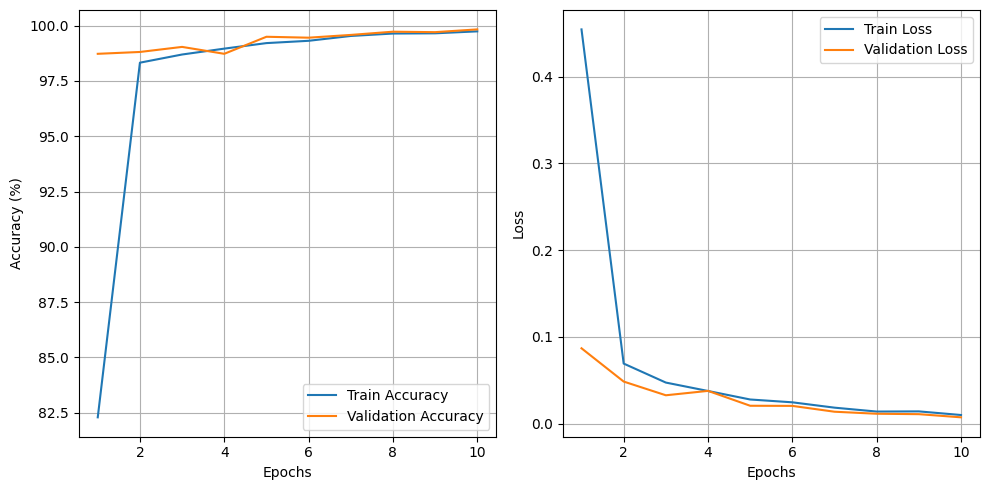

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), best_epoch_train_acc, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), best_epoch_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), best_epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), best_epoch_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f'./Graficas_entrenamiento/v4/representacion_1/longitud_8/CNN1D.png')
plt.show()

***Cargar el modelo :***

In [9]:
model.load_state_dict(torch.load("./Modelos/v4/representacion_1/longitud_8/CNN1D_fold_1.pth"))
model.to(device)
model.eval()

CNN1D(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

***Evaluar el modelo :***

In [10]:
all_preds = []
all_labels = []

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
print(train_df['Type'].unique())         # Ver las clases únicas
print(train_df['Type'].value_counts())   # Ver el conteo de cada clase

***Matriz de confusión :***

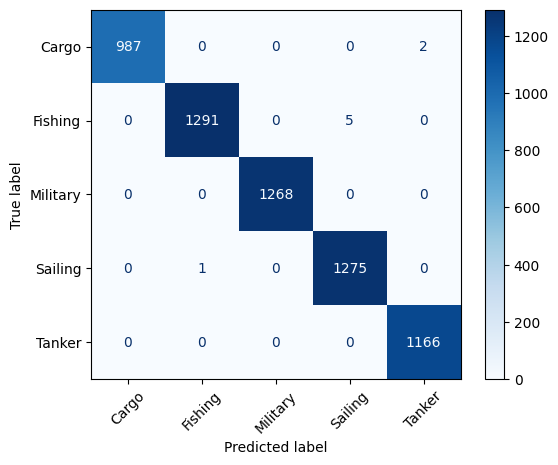

In [11]:
#class_names = ['AIS(30)','AIS(31-32)','AIS(36)','AIS(37)','AIS(52)','AIS(56-57)','AIS(60-69)','AIS(70-79)','AIS(80-89)','AIS(90-99)']
class_names = ['Cargo', 'Fishing', 'Military', 'Sailing', 'Tanker']
#class_names = ['Cargo', 'Container', 'Cruise', 'Fishing', 'Tanker']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

***Análisis de los resultados obtenidos :***

In [13]:
print(classification_report(all_labels, all_preds, target_names=class_names))

output_dir = Path('./Resultados/v4/representacion_1/longitud_8')

classification_text = classification_report(all_labels, all_preds, target_names=class_names)

with open(output_dir / 'CNN1D_report.txt', 'w') as f:
    f.write(classification_text)

              precision    recall  f1-score   support

       Cargo       1.00      1.00      1.00       989
     Fishing       1.00      1.00      1.00      1296
    Military       1.00      1.00      1.00      1268
     Sailing       1.00      1.00      1.00      1276
      Tanker       1.00      1.00      1.00      1166

    accuracy                           1.00      5995
   macro avg       1.00      1.00      1.00      5995
weighted avg       1.00      1.00      1.00      5995

